In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***Importing Libraries***

In [33]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# ***Data Loading***

<font color='red'> **Dataset Link:** https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci

In [34]:
data = pd.read_excel('/content/drive/MyDrive/projects&aProjects/A_Projects/CustomerSegmentation_Clustering/Dataset/Online Retail.xlsx')
data.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [35]:
data.shape

(541909, 8)

# ***Data PreProcessing***

## **Checking the Null Values**

In [36]:
data.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


## **Removing Null Values**

In [37]:
data.dropna(inplace=True)

## **Check Duplicate Values**

In [38]:
data.duplicated().sum()

5225

## **Removing Duplicate Values**

In [39]:
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

## **Checking Data Types**

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    401604 non-null  object        
 1   StockCode    401604 non-null  object        
 2   Description  401604 non-null  object        
 3   Quantity     401604 non-null  int64         
 4   InvoiceDate  401604 non-null  datetime64[ns]
 5   UnitPrice    401604 non-null  float64       
 6   CustomerID   401604 non-null  float64       
 7   Country      401604 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.6+ MB


In [41]:
data.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,401604.000000,401604,401604.000000,401604.000000
mean,12.183273,2011-07-10 12:08:23.848567552,3.474064,15281.160818
min,-80995.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-06 15:02:00,1.250000,13939.000000
50%,5.000000,2011-07-29 15:40:00,1.950000,15145.000000
75%,12.000000,2011-10-20 11:58:30,3.750000,16784.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,250.283037,NaN,69.764035,1714.006089


# ***Feature Engineering***

## **Calculate Total Price for each row**

In [42]:
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

## **Recency: Days since last purchase**

In [43]:
latest_date = data['InvoiceDate'].max()

## **Create RFM metrics**

In [44]:
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'InvoiceNo': 'nunique',  # Frequency: Number of invoices
    'TotalPrice': 'sum'      # Monetary: Total spend
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

## **Scaling the RFM metrics**

In [45]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# ***Explortary Data Analysis***

In [46]:
# scatter plot of Recency vs Monetary
fig = px.scatter(rfm, x="Recency", y="Monetary", color=rfm.index,
                 hover_data=['Frequency'], title="Recency vs Monetary Value")
fig.update_traces(marker=dict(size=10,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

In [47]:
# histogram of Recency
fig = px.histogram(rfm, x="Recency", nbins=30, title='Distribution of Recency')
fig.show()

In [48]:
# box plot of Monetary Value by Frequency
fig = px.box(rfm, x="Frequency", y="Monetary", points="all",
             title="Monetary Value by Frequency")
fig.show()

# ***Applying Clustering Models***

## **K-Means Clustering**

In [49]:
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['KMeans_Labels'] = kmeans.fit_predict(rfm_scaled)

## **DBSCAN Clustering**

In [50]:
dbscan = DBSCAN(eps=1.5, min_samples=2)
rfm['DBSCAN_Labels'] = dbscan.fit_predict(rfm_scaled)

# ***Evaluate Clustering Models***

## **For K-Means**

In [51]:
kmeans_silhouette = silhouette_score(rfm_scaled, rfm['KMeans_Labels'])
kmeans_davies_bouldin = davies_bouldin_score(rfm_scaled, rfm['KMeans_Labels'])

In [52]:
print(f"K-Means Silhouette Score: {kmeans_silhouette}")
print(f"K-Means Davies-Bouldin Index: {kmeans_davies_bouldin}")

K-Means Silhouette Score: 0.5882428352236619
K-Means Davies-Bouldin Index: 0.7099315031592255


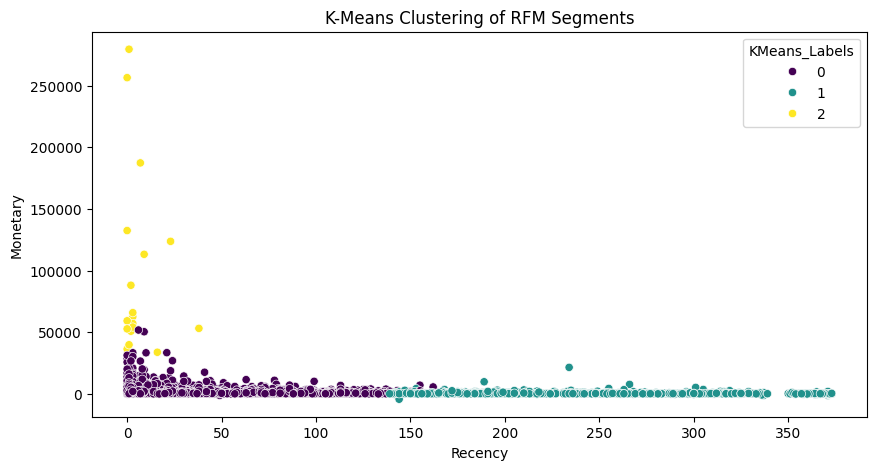

In [53]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=rfm['Recency'], y=rfm['Monetary'], hue=rfm['KMeans_Labels'], palette='viridis')
plt.title('K-Means Clustering of RFM Segments')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.show()

In [54]:
# 3D Scatter Plot for KMeans Clusters
fig = px.scatter_3d(rfm, x='Recency', y='Frequency', z='Monetary',
                    color='KMeans_Labels', title='KMeans Clustering in 3D')
fig.show()

In [55]:
print("K-Means Cluster Analysis:")
print(rfm.groupby('KMeans_Labels').mean())

K-Means Cluster Analysis:
                  Recency  Frequency      Monetary  DBSCAN_Labels
KMeans_Labels                                                    
0               39.091245   5.595561   1815.655454       0.000925
1              245.365611   1.846154    457.877422      -0.000905
2                5.086957  86.869565  81851.242609       0.521739


## **For DBSCAN8**

In [56]:
# (ignoring noise points labeled as -1)
dbscan_silhouette = silhouette_score(rfm_scaled, rfm['DBSCAN_Labels']) if len(set(rfm['DBSCAN_Labels'])) > 1 else -1
dbscan_davies_bouldin = davies_bouldin_score(rfm_scaled, rfm['DBSCAN_Labels']) if len(set(rfm['DBSCAN_Labels'])) > 1 else -1

In [57]:
print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")
print(f"DBSCAN Davies-Bouldin Index: {dbscan_davies_bouldin}")

DBSCAN Silhouette Score: 0.8207363312222021
DBSCAN Davies-Bouldin Index: 1.4736880234980654


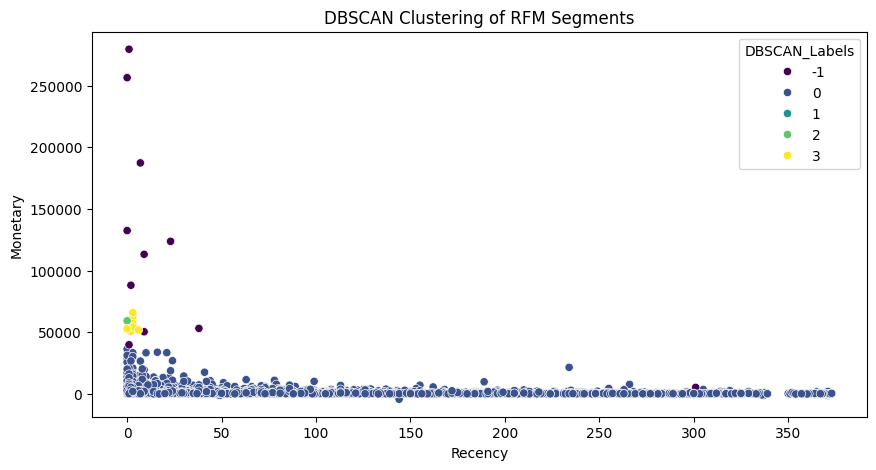

In [58]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=rfm['Recency'], y=rfm['Monetary'], hue=rfm['DBSCAN_Labels'], palette='viridis')
plt.title('DBSCAN Clustering of RFM Segments')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.show()

In [59]:
# 3D Scatter Plot for DBSCAN Clusters
fig = px.scatter_3d(rfm, x='Recency', y='Frequency', z='Monetary',
                    color='DBSCAN_Labels', title='DBSCAN Clustering in 3D')
fig.show()

In [60]:
print("\nDBSCAN Cluster Analysis:")
print(rfm.groupby('DBSCAN_Labels').mean())


DBSCAN Cluster Analysis:
                 Recency   Frequency       Monetary  KMeans_Labels
DBSCAN_Labels                                                     
-1             30.076923   94.307692  105351.496154       1.769231
 0             91.453542    4.656624    1466.958241       0.255290
 1              2.500000   87.500000    9319.975000       1.000000
 2              1.000000  118.000000   58303.160000       2.000000
 3              2.857143   43.714286   56481.324286       1.714286
